# UCF101 Action Recognition with R(2+1)D CNN

This notebook demonstrates video classification using the UCF101 dataset and a pretrained R(2+1)D model. We'll classify human actions in videos across 5 different categories.

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

# import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

## 1. Setup and Imports

Import necessary libraries for video processing, deep learning, and visualization.

In [2]:
import torch
import os
from torch import nn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from torch.utils.data import Dataset, DataLoader
import torchvision
from torchvision.utils import make_grid
from torchvision.transforms import v2
import sklearn

### Set Dataset Path and Device Configuration

In [3]:
root_path = '/kaggle/input/ucf101-action-recognition'

In [4]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

## 2. Video Loading and Visualization

Load video files using OpenCV and convert them to PyTorch tensors for processing.

In [5]:
import cv2
import torch

def load_video_cv2(path):
    cap = cv2.VideoCapture(path)
    frames = []
    while True:
        ret, frame = cap.read()
        if not ret:
            break
        # Convert BGR → RGB
        frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        frames.append(frame)
    cap.release()
    return frames  # list of H×W×3 numpy arrays

frames = load_video_cv2(f'{root_path}/train/Basketball/v_BasketballDunk_g02_c01.avi')

len(frames), frames[0].shape, frames[0] #frames is list and inside all are numpy arrays || H W 3

(56,
 (240, 320, 3),
 array([[[ 1,  0,  0],
         [ 7,  5,  6],
         [21, 19, 20],
         ...,
         [20, 18, 19],
         [ 0,  0,  0],
         [ 1,  0,  0]],
 
        [[ 1,  0,  0],
         [ 5,  3,  4],
         [19, 17, 18],
         ...,
         [20, 18, 19],
         [ 0,  0,  0],
         [ 1,  0,  0]],
 
        [[ 0,  0,  0],
         [ 4,  2,  3],
         [16, 14, 15],
         ...,
         [20, 18, 19],
         [ 0,  0,  0],
         [ 1,  0,  0]],
 
        ...,
 
        [[ 0,  4, 10],
         [ 0,  0,  2],
         [30, 28, 26],
         ...,
         [70, 53, 54],
         [12,  1,  8],
         [ 2,  0,  0]],
 
        [[ 0,  0, 12],
         [ 0,  0,  2],
         [ 6,  3,  9],
         ...,
         [41, 23, 32],
         [17,  5, 19],
         [10,  0, 12]],
 
        [[ 0,  2, 15],
         [ 0,  0,  7],
         [ 0,  0,  2],
         ...,
         [ 1,  0,  0],
         [15,  3, 17],
         [21,  9, 23]]], dtype=uint8))

### Visualize Sample Frame

Display a single frame from the loaded video to verify the data.

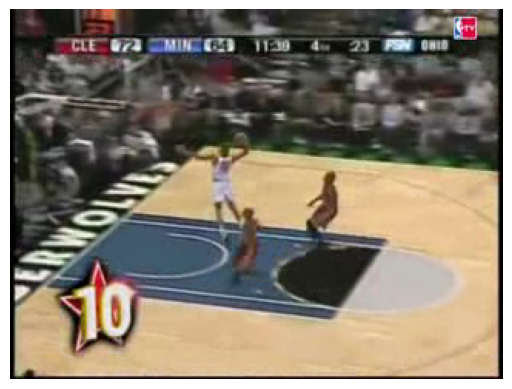

In [6]:
import matplotlib.pyplot as plt

plt.imshow(frames[20])
plt.axis(False)
plt.show()

### Create Frame Visualization Function

Helper function to display multiple video frames in a grid layout.

In [7]:
from torchvision.utils import make_grid

def plot_frames(frames_tensor, sampled = False):
    frames_tensor = frames_tensor.to('cpu')
    img_grid = make_grid(tensor = frames_tensor.permute(1,0,2, 3) if sampled else frames_tensor,  padding = 5 , nrow = 20, normalize= True)
    plt.figure(figsize=(30, 20)) 
    plt.imshow(img_grid.permute(1,2,0))
    plt.axis('off')
    plt.show()

## 3. Data Preprocessing

Convert video frames to tensors with proper normalization.

In [8]:
import numpy as np
from torchvision.transforms import v2

preprocess = v2.Compose([
    v2.ToImage(),
    v2.ToDtype(torch.float32, scale=True),
])

img1 = preprocess(frames[0])

frames_tensor = torch.stack([preprocess(f) for f in frames])  # frame tensor : T C H W
frames_tensor.shape

torch.Size([56, 3, 240, 320])

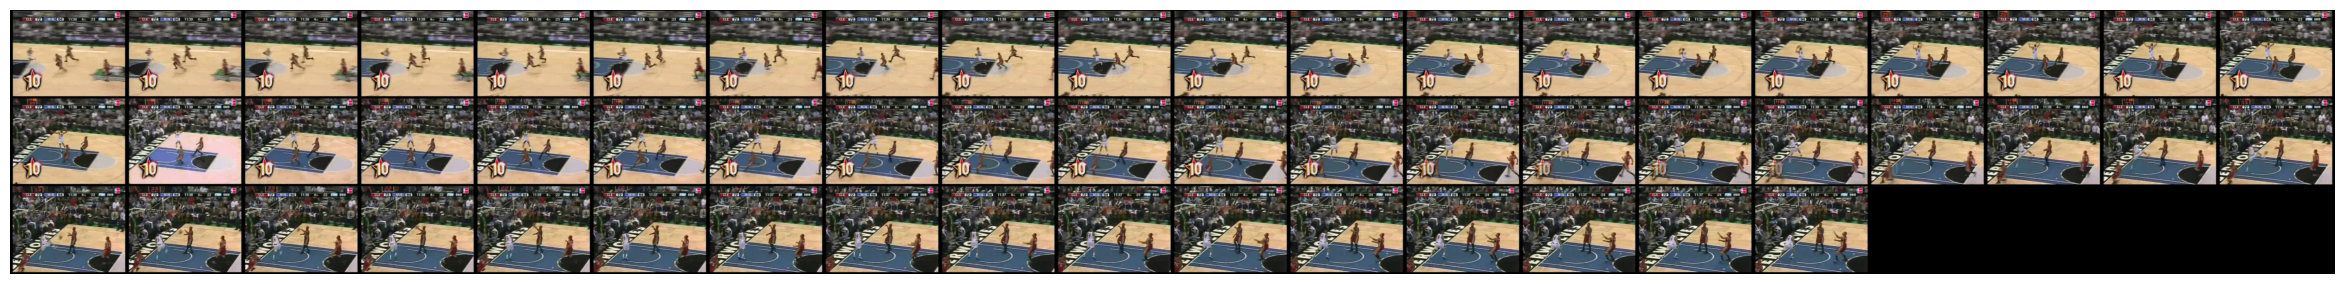

In [9]:
plot_frames(frames_tensor) #expect T C H W if not sampled

### Temporal Sampling and Padding

Implement uniform sampling to standardize video lengths - sample 16 frames from longer videos or pad shorter ones.

In [10]:
import numpy as np
import torch

def uniform_sample_or_pad(frames_tensor, num_frames=16):
    """
    Works with input shape [C, T, H, W].
    Output: same shape order, [C, num_frames, H, W].
    """
    total = frames_tensor.shape[1]  # time dimension

    # too many frames → uniform sampling
    if total > num_frames:
        idx = np.linspace(0, total - 1, num_frames).astype(int)
        frames_tensor = frames_tensor[:, idx, :, :]

    # too few → pad with last frame
    elif total < num_frames:
        pad = frames_tensor[:, -1:].repeat(1, num_frames - total, 1, 1)
        frames_tensor = torch.cat([frames_tensor, pad], dim=1)

    return frames_tensor


In [11]:
new_frames_tensor = uniform_sample_or_pad(frames_tensor.permute(1, 0, 2, 3)) #Expect CTHW returns CTHW
new_frames_tensor.shape

torch.Size([3, 16, 240, 320])

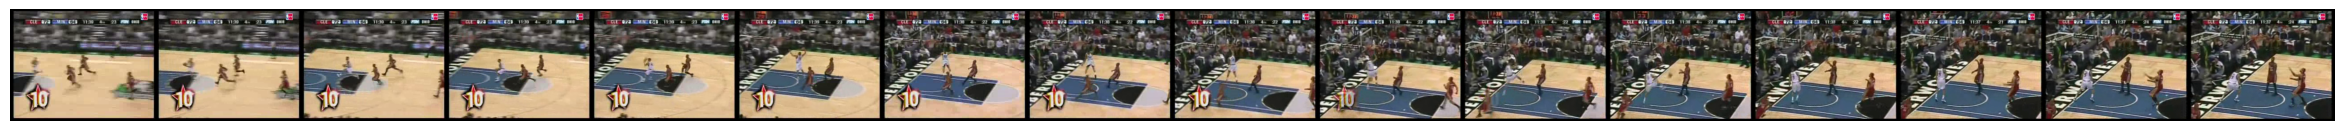

In [12]:
plot_frames(new_frames_tensor, True)

## 4. Dataset Exploration

Load and analyze the training CSV to understand class distribution.

In [13]:
import pandas as pd
train_csv = pd.read_csv('/kaggle/input/ucf101-action-recognition/train.csv')
train_csv.head()

clip_name                         clip_path  label
0  v_Swing_g05_c02  /train/Swing/v_Swing_g05_c02.avi  Swing
1  v_Swing_g21_c03  /train/Swing/v_Swing_g21_c03.avi  Swing
2  v_Swing_g07_c01  /train/Swing/v_Swing_g07_c01.avi  Swing
3  v_Swing_g24_c04  /train/Swing/v_Swing_g24_c04.avi  Swing
4  v_Swing_g20_c03  /train/Swing/v_Swing_g20_c03.avi  Swing

In [14]:
import matplotlib.pyplot as plt

# Count videos per class
class_counts = train_csv['label'].value_counts()  # Series: index=class, value=count


### Visualize Class Distribution

Plot the number of videos per class in the full training dataset.

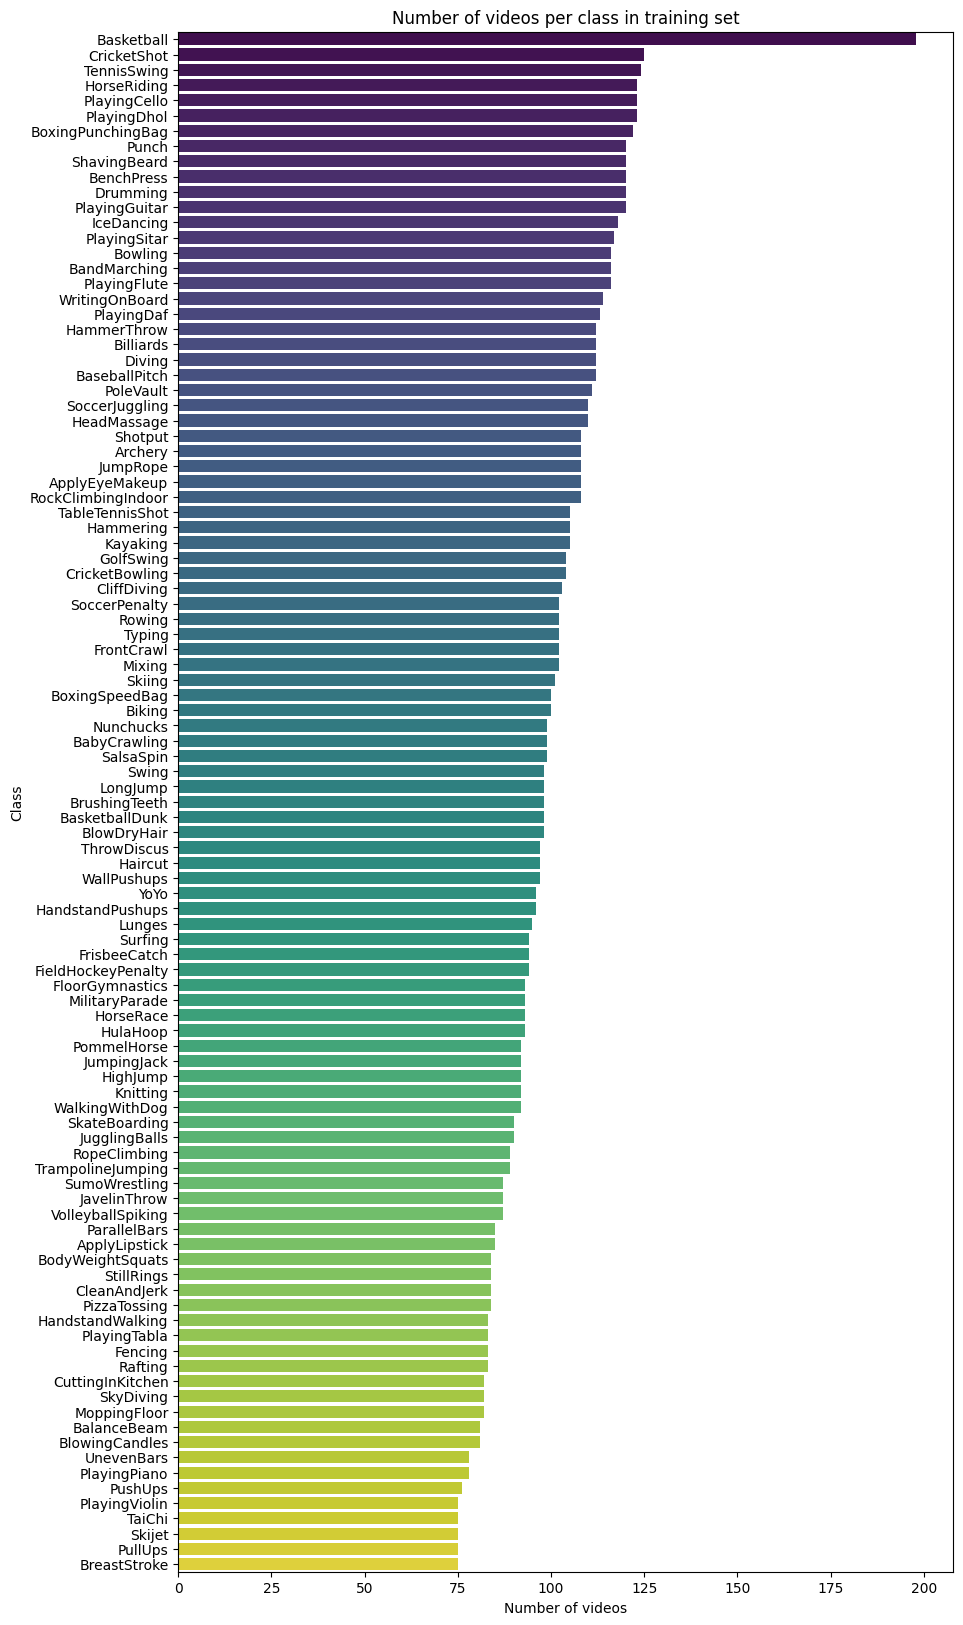

In [15]:
plt.figure(figsize=(10, 20))
sns.barplot(x=class_counts.values, y=class_counts.index, palette="viridis")
plt.xlabel("Number of videos")
plt.ylabel("Class")
plt.title("Number of videos per class in training set")
plt.show()


### Filter Dataset for Selected Classes

Select only 5 action classes for this project: CricketShot, Basketball, TennisSwing, PlayingCello, and HorseRiding.

In [16]:
LABELS = ['CricketShot', 'Basketball', 'TennisSwing', 'PlayingCello', 'HorseRiding']

new_train_csv = train_csv.copy()
new_train_csv = new_train_csv[new_train_csv['label'].isin(LABELS)]

new_train_csv.describe()

clip_name                                     clip_path  \
count                     693                                           693   
unique                    693                                           693   
top     v_CricketShot_g03_c06  /train/CricketShot/v_CricketShot_g03_c06.avi   
freq                        1                                             1   

             label  
count          693  
unique           5  
top     Basketball  
freq           198

In [17]:
new_train_csv['label'].value_counts()

label
Basketball      198
CricketShot     125
TennisSwing     124
HorseRiding     123
PlayingCello    123
Name: count, dtype: int64

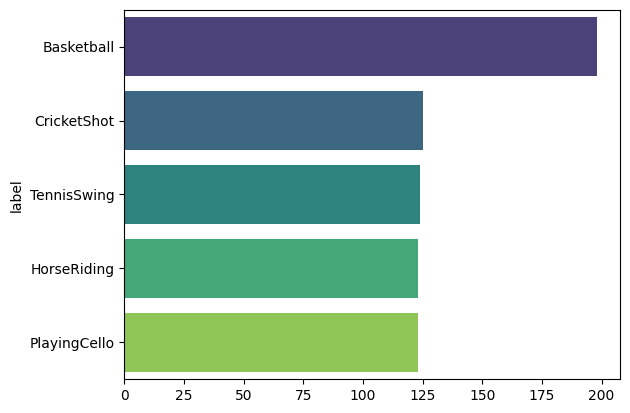

In [18]:
sns.barplot(x = new_train_csv['label'].value_counts().values, y = new_train_csv['label'].value_counts().index , palette="viridis")
plt.show()

### Encode Labels

Create label-to-index mapping and encode class labels numerically.

In [19]:
label_to_idx = {label: idx for idx, label in enumerate(sorted(LABELS))}
label_to_idx

{'Basketball': 0,
 'CricketShot': 1,
 'HorseRiding': 2,
 'PlayingCello': 3,
 'TennisSwing': 4}

In [20]:
new_train_csv['label_encoded'] = new_train_csv['label'].map(label_to_idx)
new_train_csv = new_train_csv.sort_values(by = 'label_encoded').reset_index(drop = True)
new_train_csv.head()

clip_name                                       clip_path  \
0      v_Basketball_g25_c01      /train/Basketball/v_Basketball_g25_c01.avi   
1      v_Basketball_g08_c01      /train/Basketball/v_Basketball_g08_c01.avi   
2      v_Basketball_g18_c02      /train/Basketball/v_Basketball_g18_c02.avi   
3  v_BasketballDunk_g01_c01  /train/Basketball/v_BasketballDunk_g01_c01.avi   
4  v_BasketballDunk_g14_c06  /train/Basketball/v_BasketballDunk_g14_c06.avi   

        label  label_encoded  
0  Basketball              0  
1  Basketball              0  
2  Basketball              0  
3  Basketball              0  
4  Basketball              0

## 5. Custom Dataset Class

Create a PyTorch Dataset to load videos from the CSV file with proper transformations.

In [21]:
from torch.utils.data import Dataset

class VideoFolderCustom(Dataset):
    def __init__(self, csv_df, transform = None):
        self.df = csv_df.sort_values(by = 'clip_path').reset_index(drop = True)
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        vid_path = root_path + row['clip_path']
        label = row['label_encoded']

        frames = load_video_cv2(vid_path)
        frames_tensor = torch.stack([torch.from_numpy(f) for f in frames])  # [T, H, W, C]

        if self.transform:             
            frames_tensor = self.transform(frames_tensor.permute(0,3,1,2)) # model transform expect TCHW and returns CTHW
            frames_tensor = uniform_sample_or_pad(frames_tensor) #uniform expect CTHW and returns CTHW
            return frames_tensor, label
            
        return frames_tensor, label

## 6. Model Architecture

Load pretrained R(2+1)D model - a 3D CNN architecture designed for video understanding.

In [22]:
import torchvision.models.video as models

from torch import nn
model = models.r2plus1d_18(weights = 'KINETICS400_V1')
model

Downloading: "https://download.pytorch.org/models/r2plus1d_18-91a641e6.pth" to /root/.cache/torch/hub/checkpoints/r2plus1d_18-91a641e6.pth
100%|██████████| 120M/120M [00:00<00:00, 203MB/s] 


VideoResNet(
  (stem): R2Plus1dStem(
    (0): Conv3d(3, 45, kernel_size=(1, 7, 7), stride=(1, 2, 2), padding=(0, 3, 3), bias=False)
    (1): BatchNorm3d(45, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv3d(45, 64, kernel_size=(3, 1, 1), stride=(1, 1, 1), padding=(1, 0, 0), bias=False)
    (4): BatchNorm3d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
  )
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Sequential(
        (0): Conv2Plus1D(
          (0): Conv3d(64, 144, kernel_size=(1, 3, 3), stride=(1, 1, 1), padding=(0, 1, 1), bias=False)
          (1): BatchNorm3d(144, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
          (3): Conv3d(144, 64, kernel_size=(3, 1, 1), stride=(1, 1, 1), padding=(1, 0, 0), bias=False)
        )
        (1): BatchNorm3d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=Tru

In [23]:
!pip install torchinfo

### Model Summary

Visualize model architecture and parameters before modification.

In [24]:
from torchinfo import summary

summary(model=model, 
        input_size=(32, 3, 16, 112, 112), # make sure this is "input_size", not "input_shape"
        # col_names=["input_size"], # uncomment for smaller output
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=22,
        row_settings=["var_names"]
) 

Layer (type (var_name))                       Input Shape            Output Shape           Param #                Trainable
VideoResNet (VideoResNet)                     [32, 3, 16, 112, 112]  [32, 400]              --                     True
├─R2Plus1dStem (stem)                         [32, 3, 16, 112, 112]  [32, 64, 16, 56, 56]   --                     True
│    └─Conv3d (0)                             [32, 3, 16, 112, 112]  [32, 45, 16, 56, 56]   6,615                  True
│    └─BatchNorm3d (1)                        [32, 45, 16, 56, 56]   [32, 45, 16, 56, 56]   90                     True
│    └─ReLU (2)                               [32, 45, 16, 56, 56]   [32, 45, 16, 56, 56]   --                     --
│    └─Conv3d (3)                             [32, 45, 16, 56, 56]   [32, 64, 16, 56, 56]   8,640                  True
│    └─BatchNorm3d (4)                        [32, 64, 16, 56, 56]   [32, 64, 16, 56, 56]   128                    True
│    └─ReLU (5)                      

### Modify Output Layer for Transfer Learning

Freeze all pretrained layers and replace the final classification layer to match our 5 classes.

In [25]:
for params in model.parameters():
    params.requires_grad = False

num_classes = len(LABELS)

model.fc = nn.Linear(
    in_features = model.fc.in_features,
    out_features = num_classes
)

summary(model=model, 
        input_size=(32, 3, 16, 112, 112), # make sure this is "input_size", not "input_shape"
        # col_names=["input_size"], # uncomment for smaller output
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=22,
        row_settings=["var_names"]
) 

Layer (type (var_name))                       Input Shape            Output Shape           Param #                Trainable
VideoResNet (VideoResNet)                     [32, 3, 16, 112, 112]  [32, 5]                --                     Partial
├─R2Plus1dStem (stem)                         [32, 3, 16, 112, 112]  [32, 64, 16, 56, 56]   --                     False
│    └─Conv3d (0)                             [32, 3, 16, 112, 112]  [32, 45, 16, 56, 56]   (6,615)                False
│    └─BatchNorm3d (1)                        [32, 45, 16, 56, 56]   [32, 45, 16, 56, 56]   (90)                   False
│    └─ReLU (2)                               [32, 45, 16, 56, 56]   [32, 45, 16, 56, 56]   --                     --
│    └─Conv3d (3)                             [32, 45, 16, 56, 56]   [32, 64, 16, 56, 56]   (8,640)                False
│    └─BatchNorm3d (4)                        [32, 64, 16, 56, 56]   [32, 64, 16, 56, 56]   (128)                  False
│    └─ReLU (5)              

### Model Transforms

Get the preprocessing transforms from the pretrained model weights.

In [26]:
Weights = models.R2Plus1D_18_Weights.KINETICS400_V1
Weights.meta['_docs']

'The weights reproduce closely the accuracy of the paper. The accuracies are estimated on video-level with parameters `frame_rate=15`, `clips_per_video=5`, and `clip_len=16`.'

In [27]:
model_transform = Weights.transforms()
model_transform

VideoClassification(
    crop_size=[112, 112]
    resize_size=[128, 171]
    mean=[0.43216, 0.394666, 0.37645]
    std=[0.22803, 0.22145, 0.216989]
    interpolation=InterpolationMode.BILINEAR
)

## 7. Prepare Test Dataset

Load and preprocess the test dataset with the same filtering and encoding.

In [28]:
test_csv = pd.read_csv('/kaggle/input/ucf101-action-recognition/test.csv')
new_test_csv = test_csv.copy()
new_test_csv = new_test_csv[new_test_csv['label'].isin(LABELS)]
new_test_csv.describe()

clip_name                                    clip_path  \
count                     118                                          118   
unique                    118                                          118   
top     v_CricketShot_g24_c01  /test/CricketShot/v_CricketShot_g24_c01.avi   
freq                        1                                            1   

             label  
count          118  
unique           5  
top     Basketball  
freq            34

In [ ]:
new_test_csv.info()

In [29]:
new_test_csv['label_encoded'] = new_test_csv['label'].map(label_to_idx)
new_test_csv = new_test_csv.sort_values(by = 'label_encoded').reset_index(drop = True)
new_test_csv.head()

clip_name                                      clip_path  \
0      v_Basketball_g01_c02      /test/Basketball/v_Basketball_g01_c02.avi   
1  v_BasketballDunk_g22_c04  /test/Basketball/v_BasketballDunk_g22_c04.avi   
2  v_BasketballDunk_g14_c01  /test/Basketball/v_BasketballDunk_g14_c01.avi   
3      v_Basketball_g03_c05      /test/Basketball/v_Basketball_g03_c05.avi   
4      v_Basketball_g25_c05      /test/Basketball/v_Basketball_g25_c05.avi   

        label  label_encoded  
0  Basketball              0  
1  Basketball              0  
2  Basketball              0  
3  Basketball              0  
4  Basketball              0

### Create Dataset Instances

Initialize train and test datasets with model transforms.

In [30]:
train_data = VideoFolderCustom(new_train_csv, model_transform )
test_data = VideoFolderCustom(new_test_csv, model_transform)

train_vid , train_label = train_data[0]
test_vid, test_label = test_data[0]
train_vid.shape, test_vid.shape, train_label, test_label

(torch.Size([3, 16, 112, 112]), torch.Size([3, 16, 112, 112]), 0, 0)

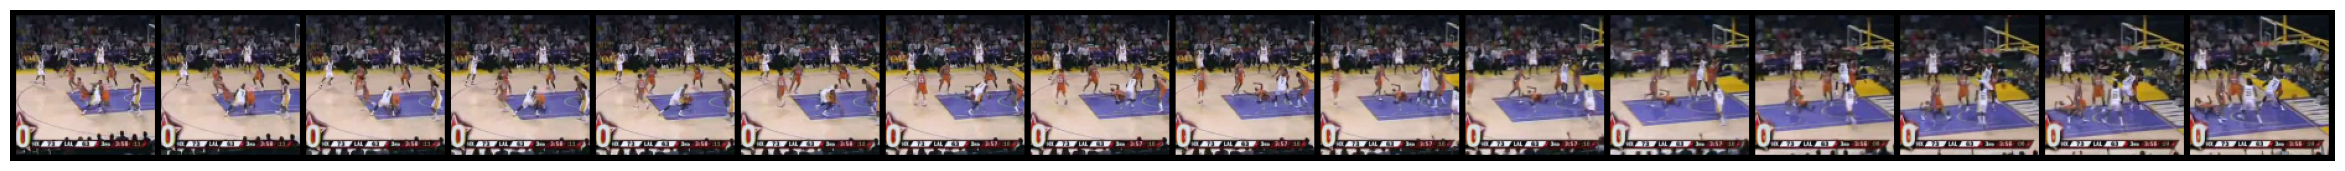

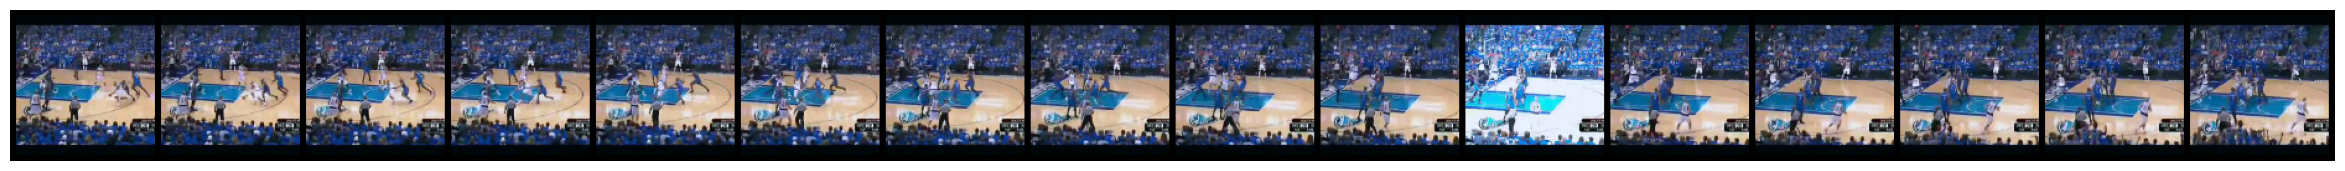

(None, None)

In [31]:
plot_frames(train_vid , sampled = True) ,plot_frames(test_vid , sampled = True)  

### Create DataLoaders

Set up batching and parallel loading for efficient training.

In [32]:
BATCH_SIZE = 4
NUM_WORKERS = os.cpu_count()

train_dataloader = DataLoader(
    dataset = train_data,
    shuffle = True,
    num_workers = NUM_WORKERS,
    batch_size = BATCH_SIZE
)


test_dataloader = DataLoader(
    dataset = test_data,
    shuffle = True,
    num_workers = NUM_WORKERS,
    batch_size = BATCH_SIZE
)

train_dataloader, test_dataloader

(<torch.utils.data.dataloader.DataLoader at 0x7a19083cef50>,
 <torch.utils.data.dataloader.DataLoader at 0x7a19083efc90>)

## 8. Training Functions

Define training and testing step functions to iterate through one epoch.

In [33]:

import torch

from tqdm.auto import tqdm
from typing import Dict, List, Tuple

def train_step(model: torch.nn.Module, 
               dataloader: torch.utils.data.DataLoader, 
               loss_fn: torch.nn.Module, 
               optimizer: torch.optim.Optimizer,
               device: torch.device) -> Tuple[float, float]:
  """Trains a PyTorch model for a single epoch.

  Turns a target PyTorch model to training mode and then
  runs through all of the required training steps (forward
  pass, loss calculation, optimizer step).

  Args:
    model: A PyTorch model to be trained.
    dataloader: A DataLoader instance for the model to be trained on.
    loss_fn: A PyTorch loss function to minimize.
    optimizer: A PyTorch optimizer to help minimize the loss function.
    device: A target device to compute on (e.g. "cuda" or "cpu").

  Returns:
    A tuple of training loss and training accuracy metrics.
    In the form (train_loss, train_accuracy). For example:

    (0.1112, 0.8743)
  """
  # Put model in train mode
  model.train()

  # Setup train loss and train accuracy values
  train_loss, train_acc = 0, 0

  # Loop through data loader data batches
  for batch, (X, y) in enumerate(dataloader):
      # Send data to target device
      X, y = X.to(device), y.to(device)

      # 1. Forward pass
      y_pred = model(X)

      # 2. Calculate  and accumulate loss
      loss = loss_fn(y_pred, y)
      train_loss += loss.item() 

      # 3. Optimizer zero grad
      optimizer.zero_grad()

      # 4. Loss backward
      loss.backward()

      # 5. Optimizer step
      optimizer.step()

      # Calculate and accumulate accuracy metric across all batches
      y_pred_class = torch.argmax(torch.softmax(y_pred, dim=1), dim=1)
      train_acc += (y_pred_class == y).sum().item()/len(y_pred)

  # Adjust metrics to get average loss and accuracy per batch 
  train_loss = train_loss / len(dataloader)
  train_acc = train_acc / len(dataloader)
  return train_loss, train_acc

def test_step(model: torch.nn.Module, 
              dataloader: torch.utils.data.DataLoader, 
              loss_fn: torch.nn.Module,
              device: torch.device) -> Tuple[float, float]:
  """Tests a PyTorch model for a single epoch.

  Turns a target PyTorch model to "eval" mode and then performs
  a forward pass on a testing dataset.

  Args:
    model: A PyTorch model to be tested.
    dataloader: A DataLoader instance for the model to be tested on.
    loss_fn: A PyTorch loss function to calculate loss on the test data.
    device: A target device to compute on (e.g. "cuda" or "cpu").

  Returns:
    A tuple of testing loss and testing accuracy metrics.
    In the form (test_loss, test_accuracy). For example:

    (0.0223, 0.8985)
  """
  # Put model in eval mode
  model.eval() 

  # Setup test loss and test accuracy values
  test_loss, test_acc = 0, 0
  all_preds, all_labels = [], []

  # Turn on inference context manager
  with torch.inference_mode():
      # Loop through DataLoader batches
      for batch, (X, y) in enumerate(dataloader):
          # Send data to target device
          X, y = X.to(device), y.to(device)

          # 1. Forward pass
          test_pred_logits = model(X)

          # 2. Calculate and accumulate loss
          loss = loss_fn(test_pred_logits, y)
          test_loss += loss.item()

          # Calculate and accumulate accuracy
          test_pred_labels = test_pred_logits.argmax(dim=1)
          test_acc += ((test_pred_labels == y).sum().item()/len(test_pred_labels))

          # Store results for later analysis
          all_preds.extend(test_pred_labels.cpu().numpy())
          all_labels.extend(y.cpu().numpy())

  # Adjust metrics to get average loss and accuracy per batch 
  test_loss = test_loss / len(dataloader)
  test_acc = test_acc / len(dataloader)
  return test_loss, test_acc,  all_preds, all_labels



### Main Training Loop

Combined training function that runs for multiple epochs and tracks metrics.

In [34]:
from timeit import default_timer as Timer
def train(model: torch.nn.Module, 
          train_dataloader: torch.utils.data.DataLoader, 
          test_dataloader: torch.utils.data.DataLoader, 
          optimizer: torch.optim.Optimizer,
          loss_fn: torch.nn.Module,
          epochs: int,
          device: torch.device) -> Dict[str, List]:
    
  """Trains and tests a PyTorch model.

  Passes a target PyTorch models through train_step() and test_step()
  functions for a number of epochs, training and testing the model
  in the same epoch loop.

  Calculates, prints and stores evaluation metrics throughout.

  Args:
    model: A PyTorch model to be trained and tested.
    train_dataloader: A DataLoader instance for the model to be trained on.
    test_dataloader: A DataLoader instance for the model to be tested on.
    optimizer: A PyTorch optimizer to help minimize the loss function.
    loss_fn: A PyTorch loss function to calculate loss on both datasets.
    epochs: An integer indicating how many epochs to train for.
    device: A target device to compute on (e.g. "cuda" or "cpu").

  Returns:
    A dictionary of training and testing loss as well as training and
    testing accuracy metrics. Each metric has a value in a list for 
    each epoch.
    In the form: {train_loss: [...],
                  train_acc: [...],
                  test_loss: [...],
                  test_acc: [...]
                  total_time : } 
    For example if training for epochs=2: 
                 {train_loss: [2.0616, 1.0537],
                  train_acc: [0.3945, 0.3945],
                  test_loss: [1.2641, 1.5706],
                  test_acc: [0.3400, 0.2973]
                  total_time : 300s} 
  """
  # Create empty results dictionary
  results = {
      "train_loss": [],
      "train_acc": [],
      "test_loss": [],
      "test_acc": [],
      'all_preds' : [],
      'all_labels' : [],      
  }


  start_time = Timer() 
  # Loop through training and testing steps for a number of epochs
  for epoch in tqdm(range(epochs)):
      train_loss, train_acc = train_step(model=model,
                                          dataloader=train_dataloader,
                                          loss_fn=loss_fn,
                                          optimizer=optimizer,
                                          device=device)
      test_loss, test_acc,all_preds, all_labels  = test_step(model=model,
          dataloader=test_dataloader,
          loss_fn=loss_fn,
          device=device)

      # Print out what's happening
      print(
          f"Epoch: {epoch+1} | "
          f"train_loss: {train_loss:.4f} | "
          f"train_acc: {train_acc:.4f} | "
          f"test_loss: {test_loss:.4f} | "
          f"test_acc: {test_acc:.4f}"
      )

      # Update results dictionary
      results["train_loss"].append(train_loss)
      results["train_acc"].append(train_acc)
      results["test_loss"].append(test_loss)
      results["test_acc"].append(test_acc)
      
  end_time = Timer()
    
  results['total_time'] = end_time - start_time
  results['all_preds'] = all_preds
  results['all_labels'] = all_labels
  # Return the filled results at the end of the epochs
  return results

## 9. Training Configuration

Set up loss function with class weights to handle imbalanced data, and configure optimizer.

In [35]:
counts = train_csv['label'].value_counts()

# make sure the order of weights matches your class index mapping (label_to_idx).
weights = torch.tensor([
    1.0 / counts[label] for label in sorted(label_to_idx.keys())
], dtype=torch.float)

weights = weights / weights.sum()


In [36]:
model.to(device)
loss_fn = nn.CrossEntropyLoss(weight=weights.to(device))

optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-4)


### Train the Model

Run training for 5 epochs and collect results.

In [37]:
results = train(
    model = model,
    train_dataloader = train_dataloader,
    test_dataloader = test_dataloader,
    optimizer = optimizer,
    loss_fn = loss_fn,
    epochs = 5,
    device = device
)


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.9726 | train_acc: 0.6480 | test_loss: 0.3633 | test_acc: 0.8667
Epoch: 2 | train_loss: 0.5098 | train_acc: 0.8520 | test_loss: 0.1407 | test_acc: 0.9833
Epoch: 3 | train_loss: 0.3880 | train_acc: 0.8879 | test_loss: 0.1205 | test_acc: 0.9667
Epoch: 4 | train_loss: 0.3821 | train_acc: 0.8764 | test_loss: 0.1369 | test_acc: 0.9583
Epoch: 5 | train_loss: 0.3342 | train_acc: 0.8894 | test_loss: 0.0978 | test_acc: 0.9667


## 10. Results Visualization

Plot training and testing metrics to evaluate model performance.

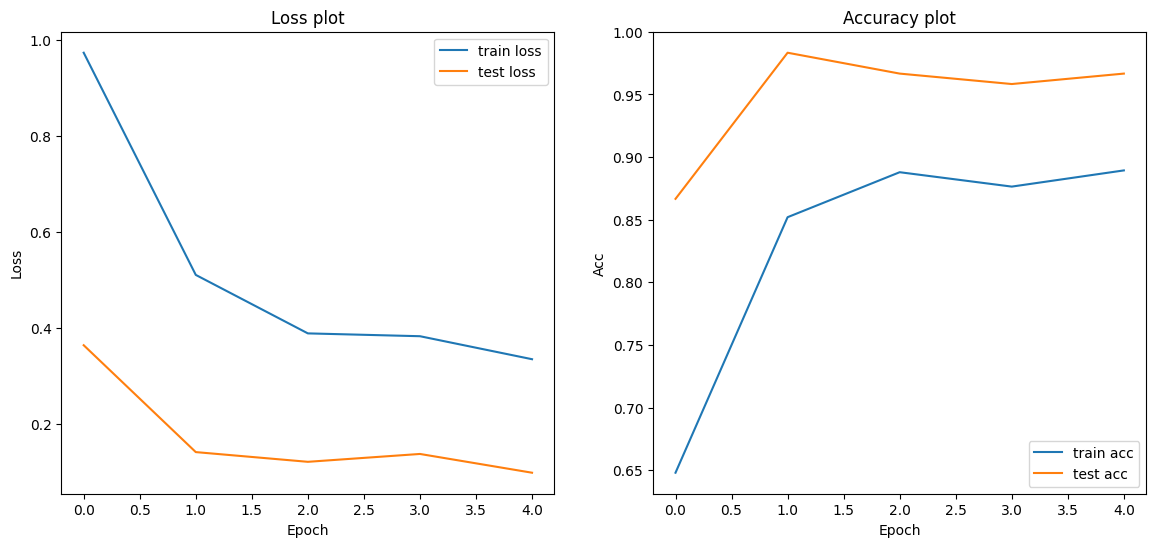

In [38]:
plt.figure(figsize = (14,6))

plt.subplot(1,2,1)
plt.title("Loss plot")
plt.plot(results["train_loss"], label = 'train loss')
plt.plot(results["test_loss"], label = 'test loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1,2,2)
plt.title("Accuracy plot")
plt.plot(results["train_acc"], label = 'train acc')
plt.plot(results["test_acc"], label = 'test acc')
plt.xlabel('Epoch')
plt.ylabel('Acc')
plt.legend()


plt.show()

In [39]:
results

{'train_loss': [0.9725614106175543,
  0.5097836724471771,
  0.38798400296176644,
  0.3820916106817366,
  0.33419494817954026],
 'train_acc': [0.6479885057471264,
  0.8520114942528736,
  0.8879310344827587,
  0.8764367816091954,
  0.889367816091954],
 'test_loss': [0.363325992350777,
  0.14073091838508844,
  0.12049130615778267,
  0.1368575431833354,
  0.09777294922775279],
 'test_acc': [0.8666666666666667,
  0.9833333333333333,
  0.9666666666666667,
  0.9583333333333334,
  0.9666666666666667],
 'all_preds': [2,
  0,
  3,
  0,
  0,
  2,
  4,
  2,
  0,
  1,
  4,
  0,
  4,
  1,
  4,
  4,
  4,
  0,
  3,
  2,
  0,
  1,
  1,
  2,
  0,
  2,
  1,
  1,
  1,
  1,
  0,
  1,
  1,
  1,
  4,
  2,
  3,
  2,
  3,
  1,
  1,
  0,
  3,
  1,
  3,
  3,
  3,
  3,
  0,
  3,
  1,
  0,
  4,
  4,
  0,
  4,
  1,
  0,
  0,
  3,
  1,
  0,
  0,
  4,
  0,
  4,
  0,
  3,
  0,
  3,
  2,
  0,
  2,
  3,
  0,
  3,
  2,
  4,
  1,
  0,
  2,
  0,
  3,
  0,
  0,
  0,
  2,
  1,
  2,
  2,
  4,
  2,
  3,
  2,
  3,
  4,
  2,
  0

### Confusion Matrix

Analyze model predictions by class to identify where the model performs well or struggles.

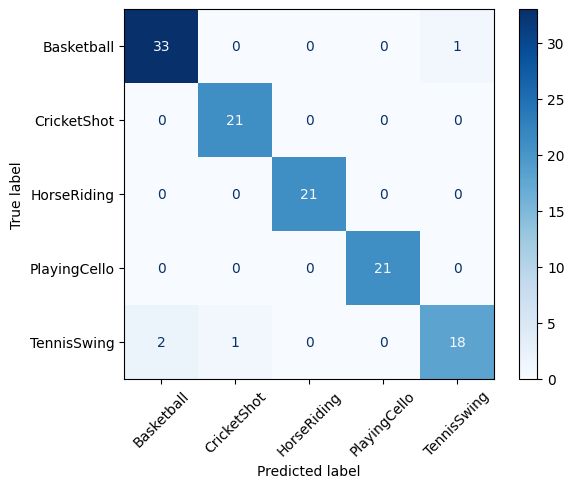

In [40]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
y_true = results['all_labels']
y_pred = results['all_preds']

cm = confusion_matrix(y_true, y_pred)

disp = ConfusionMatrixDisplay(
    confusion_matrix = cm,
    display_labels = sorted(label_to_idx.keys())
)

disp.plot(cmap='Blues', xticks_rotation=45)
